In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from scipy.stats import pareto

### Simulations Adapted from Esquivel et al. (2024): Pareto-Distributed Flare Injection

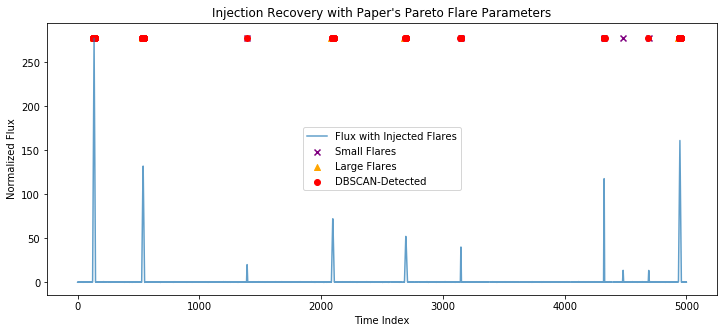


=== Flare Detection Evaluation ===
True Positives: 9
False Positives: 0
False Negatives: 1
Precision: 1.0
Recall (TPR): 0.9
F1 Score: 0.947
Matched Windows: [(1387, 1397), (3143, 3153), (4319, 4329), (4686, 4696), (123, 148), (526, 551), (2084, 2109), (2684, 2709), (4934, 4959)]
Missed Windows: [(4475, 4485)]
Unmatched Detected Flares: []


In [2]:
np.random.seed(200)

# =====================
# 1. Generate Simulated Light Curve (Gaussian noise baseline)
# =====================
time_steps = 5000
flux = np.random.normal(1, 0.02, time_steps)
df = pd.DataFrame({'index': np.arange(time_steps), 'pdcsap_flux': flux})

# Normalize flux
scaler = MinMaxScaler()
df['pdcsap_flux'] = scaler.fit_transform(df[['pdcsap_flux']])

# =====================
# 2. Inject Small and Large Flares (Paper Parameters adapted to shorter time series)
# =====================
def inject_custom_pareto_flares(data, num_flares, xm, alpha, delta, duration):
    """
    Injects synthetic stellar flares into a light curve using a Pareto-distributed flare amplitude model.

    Parameters:
    ----------
    data : pandas.DataFrame  
        DataFrame containing a 'pdcsap_flux' column to inject flares into.
    num_flares : int  
        Number of flares to inject.
    xm : float  
        Scale parameter for the Pareto distribution (minimum possible flare intensity).
    alpha : float  
        Shape parameter for the Pareto distribution (controls tail heaviness).
    delta : int  
        Time offset from flare peak to start of injection (controls rise time).
    duration : int  
        Total duration (in time steps) of each flare.

    Returns:
    -------
    data : pandas.DataFrame  
        Modified DataFrame with injected flares added to 'pdcsap_flux'.
    flare_times : np.ndarray  
        Time indices of flare peaks (approximate centers of each injected flare).
    flare_intensities : np.ndarray  
        Peak intensity multipliers sampled from the Pareto distribution.
    flare_ranges : list of tuples  
        Start and end index ranges where each flare was injected 
        (accounts for rise and fall around the flare peak).
    """ 
    
    # randomly pick flare injection times (away from the edges for safety) + sort them 
    flare_times = np.random.randint(100 + delta, len(data) - duration, size=num_flares)
    flare_times.sort()
    
    # Sample flare peak intensities from the Pareto distribution 
    flare_intensities = pareto.rvs(alpha, scale=xm, size=num_flares)
    
    # store the (start, end) time index of each flare
    flare_ranges = []

    for i, t in enumerate(flare_times):
        # For each flare, determine its peak flux relative to recent baseline values
        peak_flux = np.max(data['pdcsap_flux'][max(0, t-10):t]) * flare_intensities[i]
        
        # Generate a symmetric rise and fall for the flare
        half_duration = duration // 2
        flare_curve = np.linspace(0, peak_flux, half_duration).tolist() + np.linspace(peak_flux, 0, duration - half_duration).tolist()
        
        # Ensure injection doesn’t go out of bounds
        inject_start = t - delta
        end_idx = min(inject_start + len(flare_curve), len(data))
        adjusted_curve = flare_curve[:end_idx - inject_start]
        
        # Inject the flare into the data and save its range
        data.loc[inject_start:end_idx - 1, 'pdcsap_flux'] += adjusted_curve
        flare_ranges.append((inject_start, end_idx))

    return data, flare_times, flare_intensities, flare_ranges

# Inject 5 small flares according to paper parameters (scaled down a bit)
df, small_times, small_intensities, small_ranges = inject_custom_pareto_flares(
    df, num_flares=5, xm=10, alpha=1, delta=3, duration=10 
)

# Inject 5 large flares according to paper parameters (scaled down a bit)
df, large_times, large_intensities, large_ranges = inject_custom_pareto_flares(
    df, num_flares=5, xm=50, alpha=1, delta=0, duration=25
)

# Combine all flare info for evaluation 
all_flares = sorted(list(small_times) + list(large_times))
all_intensities = np.concatenate([small_intensities, large_intensities])
all_ranges = small_ranges + large_ranges

# =====================
# 3. Feature Engineering for DBSCAN 
# =====================
optimal_window = 100
df['flux_diff'] = df['pdcsap_flux'].diff()
df['flux_ratio'] = df['pdcsap_flux'] / (df['pdcsap_flux'].shift(1) + 1e-8)
df['flux_roll_mean'] = df['pdcsap_flux'].rolling(window=optimal_window, min_periods=1).mean()
df['flux_roll_std'] = df['pdcsap_flux'].rolling(window=optimal_window, min_periods=1).std()
df.fillna(0, inplace=True) # in case of any NAs 

# =====================
# 4. DBSCAN Detection
# =====================
features = df[['flux_diff', 'flux_ratio', 'flux_roll_mean', 'flux_roll_std']]
dbscan = DBSCAN(eps=4, min_samples=50)
clusters = dbscan.fit_predict(features)
df['cluster'] = clusters

# Compute a flux threshold (top 5% brightness)
flux_thresh = df['pdcsap_flux'].quantile(0.95)
    
# Mark detected flares as outliers above flux threshold
df['is_flare'] = ((df['cluster'] == -1) & (df['pdcsap_flux'] > flux_thresh)).astype(int)

# save these DBSCAN detected points 
dbscan_flares = df[df['is_flare'] == 1]['index'].to_numpy()

# =====================
# 5. Plot Results
# =====================
plt.figure(figsize=(12,5))
plt.plot(df['index'], df['pdcsap_flux'], label='Flux with Injected Flares', alpha=0.7)

# Mark small flares
plt.scatter(small_times, [df['pdcsap_flux'].max()] * len(small_times), color='purple', label="Small Flares", marker='x')

# Mark large flares
plt.scatter(large_times, [df['pdcsap_flux'].max()] * len(large_times), color='orange', label="Large Flares", marker='^')

# Mark DBSCAN-detected flares
plt.scatter(dbscan_flares, [df['pdcsap_flux'].max()] * len(dbscan_flares), color='red', label="DBSCAN-Detected", marker='o')

plt.legend()
plt.title("Injection Recovery with Paper's Pareto Flare Parameters")
plt.xlabel("Time Index")
plt.ylabel("Normalized Flux")
plt.savefig("simulation_pareto_paper_style.png", dpi=300)
plt.show()

# =====================
# 6. Evaluation
# =====================
def evaluate_flare_detection(flare_windows, detected_times):
    
    """
    Evaluates flare detection performance by comparing detected flare times to ground truth flares.

    Parameters:
    ----------
    flare_windows : list of tuples  
        List of (start, end) index ranges representing the true time spans of injected flares.
    detected_times : list or array-like  
        Time indices of flares detected by a clustering algorithm (DBSCAN in this case).

    Returns:
    -------
    dict with keys:  
    "True Positives", "False Positives", "False Negatives", "Precision", "Recall (TPR)", 
    "F1 Score", "Matched Windows", "Missed Windows", "Unmatched Detected Flares"
    """
    
    matched_windows = []
    unmatched_detected = []
    
    # For each injected flare window, check if DBSCAN is able to capture it 
    for (start, end) in flare_windows:
        detected_in_window = any(start <= d <= end for d in detected_times)
        if detected_in_window:
            matched_windows.append((start, end))
            
    # For each detected flare, check if it coincides with true flare window      
    for d in detected_times:
        in_any_window = any(start <= d <= end for (start, end) in flare_windows)
        if not in_any_window:
            unmatched_detected.append(d)

    # matched windows 
    TP = len(matched_windows)
    # missed windows 
    FN = len(flare_windows) - TP
    # unmatched detections 
    FP = len(unmatched_detected)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "True Positives": TP,
        "False Positives": FP,
        "False Negatives": FN,
        "Precision": round(precision, 3),
        "Recall (TPR)": round(recall, 3),
        "F1 Score": round(f1, 3),
        "Matched Windows": matched_windows,
        "Missed Windows": sorted(set(flare_windows) - set(matched_windows)),
        "Unmatched Detected Flares": unmatched_detected
    }

# Run evaluation
results = evaluate_flare_detection(all_ranges, dbscan_flares)

# Print evaluation
print("\n=== Flare Detection Evaluation ===")
for k, v in results.items():
    print(f"{k}: {v}")

### Realistic Flare Injection Simulations Using TIC 0131799991 as Baseline

In [3]:
# Load processed data for star and see summary stats 
data_star1 = pd.read_csv('data_star1.csv')
data_star1.describe()

,index,pdcsap_flux,flux_roll_mean_10,flux_roll_mean_50,flux_roll_mean_100,flux_roll_mean_200,flux_diff,flux_ratio,flux_roll_mean,flux_roll_std
count,17303.000000,17303.000000,17295.000000,17255.000000,17205.000000,17105.000000,17303.000000,17303.000000,17303.000000,17303.000000
mean,8990.000000,2492.386817,2492.388103,2492.397804,2492.384248,2492.373779,0.001439,1.000015,2492.428095,12.514413
std,4995.090189,15.482032,11.617771,8.114489,5.196995,3.489055,13.807683,0.005486,5.227910,7.595672
min,339.000000,2449.200400,2469.968550,2476.929156,2480.807166,2484.854490,-236.822700,0.919596,2480.807166,5.978873
25%,4664.500000,2483.292480,2485.318285,2486.673789,2489.229318,2490.287903,-8.211463,0.996705,2489.248077,10.409181
50%,8990.000000,2491.034781,2489.859310,2490.852406,2492.441704,2491.975145,-0.313388,0.999874,2492.467256,11.697604
75%,13315.500000,2500.436500,2498.890860,2497.655524,2494.763446,2493.551425,8.078350,1.003241,2494.799606,13.000501
max,17641.000000,3057.635500,2735.998450,2571.168656,2534.533950,2514.099464,458.258500,1.176296,2534.533950,88.650738


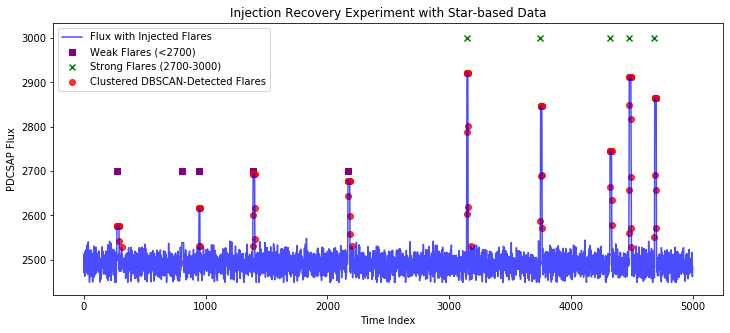

{'Injected Weak Flares (start, end)': [(270, 290), (804, 821), (944, 954), (1387, 1405), (2167, 2186)], 'Injected Strong Flares (start, end)': [(3143, 3156), (3748, 3765), (4319, 4336), (4475, 4497), (4686, 4703)], 'DBSCAN Detected Flares': [271, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 309, 944, 945, 947, 948, 949, 950, 951, 952, 953, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2200, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3177, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3761, 3762, 3763, 4320, 4321, 4322, 4323, 4324, 4325, 4326, 4327, 4328, 4329, 4330, 4331, 4332, 4333, 4334, 4335, 4475, 4477, 4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487, 4488, 4489, 4490, 4491, 4492, 4493, 4494, 4495, 4496, 

In [4]:
np.random.seed(200)

# ==========================
# 1. Generate Regular Time Series Matching Properties of the Original Data
# ==========================

time_steps = 5000 # same as simulation above 
time = np.arange(time_steps)

# Trend equaltion and seasonality computed from real star data during EDA 
trend = -3.67976984e-04 * time + 2.49462886e+03
seasonality_values = np.array([
    -1.25990343, -11.19564245, -2.077453, -0.05778935, 9.59370685, -13.27021425, -14.34880593, 
    1.4413265, -20.81744205, 1.48617883, -6.72491584, 4.32928328, -2.36833023, -9.12321078, -7.04635818, 
    2.655991, -0.12087087, 1.66202977, -6.79291525, -0.24531708, -2.2160573, 2.69874612, 8.10156508, -10.72697153,
    11.71194595, -3.25201666, -3.56503687, 6.9921768, -10.54181852, 3.09870895, 4.82359575, -17.18585551
])

# adjust to length of time series being generated 
seasonality = np.tile(seasonality_values, time_steps // len(seasonality_values) + 1)[:time_steps]

# make flux baseline = trend + seasonality 
flux_baseline = trend + seasonality

# ==========================
# 2. Generate Realistic Noise as would be expected in star brigthness data 
# ==========================

#  empirical distribution of the original flux data for this star (can be cross-checked with summary stats in above cell)
flux_min = 2449.2
flux_max = 3057.64
flux_mean = 2492.39
flux_std = 15.48

# add noise to baseline flux to make it more realistic, then clip within known physical limits
noise = np.random.normal(0, flux_std, size=time_steps)
flux_baseline += noise
flux_baseline = np.clip(flux_baseline, flux_min, flux_max)

# ==========================
# 3. Inject Flares 
# ==========================

# pick 10 random injection times, spaced away from edges.
num_flares = 10
flare_times = np.random.randint(100, time_steps - 100, size=num_flares)
flare_times.sort()

# create 2 classes of flares: 
# 1. Weak (mean + 3sd, 2700)
# 2. Strong (2700,3000)
flare_heights = np.concatenate([
    np.random.uniform(flux_mean + 3 * flux_std, 2700, size=5),
    np.random.uniform(2700, 3000, size=5)
])

# assign random durations between 10 and 25 to each flar to keep it realistic 
flare_durations = np.random.randint(10, 25, size=num_flares) 

# initialize a DataFrame and a list to store start–end windows for each flare.
df = pd.DataFrame({"index": time, "pdcsap_flux": flux_baseline})
flare_windows = []

# generate a symmetric Gaussian-like curve (the flare shape) and multiply it by a decay constant to vary the steepness
for i, t in enumerate(flare_times):
    duration = flare_durations[i]
    peak_flux = flare_heights[i]
    x = np.linspace(-2, 2, duration)
    decay_rate = np.random.uniform(0.8, 1.2)
    flare_shape = (peak_flux * np.exp(-decay_rate * x**2))  
    
    # inject the flare into the time series, capped at its peak height
    end_idx = min(t + len(flare_shape), time_steps)
    for j in range(t, end_idx):
        df.loc[j, 'pdcsap_flux'] = min(df.loc[j, 'pdcsap_flux'] + flare_shape[j - t], peak_flux)
    
    # save the start and end of the injected flare window
    flare_windows.append((t, end_idx))

# ==========================
# 4. Feature Engineering for DBSCAN
# ==========================

optimal_window = 100
df['flux_diff'] = df['pdcsap_flux'].diff()
df['flux_ratio'] = df['pdcsap_flux'] / (df['pdcsap_flux'].shift(1) + 1e-8)
df['flux_roll_mean'] = df['pdcsap_flux'].rolling(window=optimal_window, min_periods=1).mean()
df['flux_roll_std'] = df['pdcsap_flux'].rolling(window=optimal_window, min_periods=1).std()
df.fillna(0, inplace=True)

# ==========================
# 5. Apply DBSCAN
# ==========================

eps = 4
min_samples = 50
features = df[['flux_diff', 'flux_ratio', 'flux_roll_mean', 'flux_roll_std']]
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(features)
df['cluster'] = clusters

# Compute flux threshold
flux_thresh = df['pdcsap_flux'].quantile(0.95)

# Mark detected flares as outliers above flux threshold
df['is_flare'] = ((df['cluster'] == -1) & (df['pdcsap_flux'] > flux_thresh)).astype(int)

# collect temporal clusters 
def get_clustered_flares(flare_indices, window, min_cluster_size):
    
    """
    Filters flare indices to retain only those that belong to dense temporal clusters as isolated points are not 
    counted as valid flares for this study (likely noise).

    Parameters:
    ----------
    flare_indices : list of ints, time indices of detected flares  
    window : int, max time gap between consecutive flares to be in the same cluster
    min_cluster_size : int, minimum number of points required to form a valid cluster
    
    Note: window and min_cluster_size should be chosen based on prior knowledge of flare duration 
    and behaviour for the specific star being analyzed. If no such information is available, 
    it is recommended to start with small values and increase as needed. In this example, 
    they were set to 25 and 5 respectively, as flares were injected with a maximum duration of 25 time steps. 

    Returns:
    -------
    list of ints, flare indices that are part of valid clusters
    """
    
    clustered_flares = []
    flare_indices = sorted(flare_indices)
    
    if not flare_indices:
        return clustered_flares

    current_cluster = [flare_indices[0]]

    for i in range(1, len(flare_indices)):
        if flare_indices[i] - flare_indices[i - 1] <= window:
            current_cluster.append(flare_indices[i])
        else:
            if len(current_cluster) >= min_cluster_size:
                clustered_flares.extend(current_cluster)
            current_cluster = [flare_indices[i]]

    if len(current_cluster) >= min_cluster_size:
        clustered_flares.extend(current_cluster)

    return list(set(clustered_flares))

dbscan_flare_indices = df[df['is_flare'] == 1]['index'].tolist()
clustered_flare_indices = get_clustered_flares(dbscan_flare_indices, window=25, min_cluster_size=5)
df['is_flare_clustered'] = df['index'].isin(clustered_flare_indices).astype(int)

# ==========================
# 6. Plot Results 
# ==========================

plt.figure(figsize=(12, 5))
plt.plot(df['index'], df['pdcsap_flux'], label='Flux with Injected Flares', color='blue', alpha=0.7)

# Mark true flare peaks
plt.scatter(flare_times[:5], [2700] * 5, color='purple', label="Weak Flares (<2700)", marker='s')
plt.scatter(flare_times[5:], [3000] * 5, color='green', label="Strong Flares (2700-3000)", marker='x')

# DBSCAN detected
clustered_flares = df[df['is_flare_clustered'] == 1]
plt.scatter(clustered_flares['index'], clustered_flares['pdcsap_flux'], color='red', label="Clustered DBSCAN-Detected Flares", marker='o', alpha=0.8)

plt.legend()
plt.title("Injection Recovery Experiment with Star-based Data")
plt.xlabel("Time Index")
plt.ylabel("PDCSAP Flux")
plt.savefig("simulation_realstar.png", dpi=300)
plt.show()

# ==========================
# 7. Display Summary
# ==========================

print({
    "Injected Weak Flares (start, end)": flare_windows[:5],
    "Injected Strong Flares (start, end)": flare_windows[5:],
    "DBSCAN Detected Flares": clustered_flares['index'].tolist()
})

# ==========================
# 8. Evaluate Model Performance 
# ==========================

def evaluate_window_based_detection(flare_windows, detected_indices):
    
    """
    Evaluates flare detection performance by comparing detected flare times to ground truth flares.
    
    Parameters:
    ----------
    flare_windows : list of (start, end) tuples, true time ranges of injected flares 
    detected_indices : list or array of ints, time indices of detected flare points
    
    Returns:
    -------
    dict with keys:  
    "True Positives", "False Positives", "False Negatives", "Precision", "Recall (TPR)", "F1 Score", 
    "Matched Flare Windows", "Missed Flare Windows", "Unmatched Detected Flares"
    """
       
    matched = []
    unmatched_detected = []

    for start, end in flare_windows:
        if any(start <= d <= end for d in detected_indices):
            matched.append((start, end))

    for d in detected_indices:
        if not any(start <= d <= end for (start, end) in flare_windows):
            unmatched_detected.append(d)

    TP = len(matched)
    FN = len(flare_windows) - TP
    FP = len(unmatched_detected)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "True Positives": TP,
        "False Positives": FP,
        "False Negatives": FN,
        "Precision": round(precision, 3),
        "Recall (TPR)": round(recall, 3),
        "F1 Score": round(f1, 3),
        "Matched Flare Windows": matched,
        "Missed Flare Windows": sorted(set(flare_windows) - set(matched)),
        "Unmatched Detected Flares": unmatched_detected
    }

# Run new evaluation
evaluation_results = evaluate_window_based_detection(flare_windows, clustered_flare_indices)

# Print results
print("\n=== Flare Detection Evaluation ===")
for k, v in evaluation_results.items():
    print(f"{k}: {v}")